# Сегментация клиентов

## Задача

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Corporate_Woman_Shaking_Hands_With_a_Corporate_Man.svg/640px-Corporate_Woman_Shaking_Hands_With_a_Corporate_Man.svg.png "")

Стоит задача сегментировать клиентов по трем категориям (0, 1, 2). Необходимо разработать модель, предсказывающую к какому из трех сегментов относится каждый клиент.

Обучающая выборка в файле `contest_train.csv` состоит из следующих столбцов:
* `ID` — идентификаторы клиентов
* `TARGET` — соответствующий клиенту сегмент 
* `FEATURE_0`…`FEATURE_259` — данные клиента.

Точность предсказания оценивается метрикой [`macro f1 score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html). При этом для каждого класса (сегмента) рассчитывается значение метрики `F1`, а затем определяется их невзвешенное среднее.

In [ ]:
! gdown 1rW9iL3EibciyZYiSwVYTn3be9idCtTOX

In [ ]:
! gdown 1kOc2h8IiccMNzXchI-T6LWyTHQPp3a7w

In [ ]:
! pip install catboost --quiet

In [ ]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.linear_model import RidgeClassifierCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline

from catboost import CatBoostClassifier
from catboost import Pool

from lightgbm import LGBMClassifier

In [ ]:
sns.set_style('darkgrid')
sns.set_palette('colorblind')
sns.set(rc={'figure.figsize': (15, 6)})

## Загрузка и первичное ознакомление с данными

In [ ]:
df = pd.read_csv('contest_train.csv')

In [ ]:
df.head()

ID  FEATURE_0  FEATURE_1  FEATURE_2  FEATURE_3  FEATURE_4  \
0   737005990        2.0        2.0        0.0        0.0        0.0   
1   336625142        2.0        1.0        0.0        0.0        0.0   
2  1146317240       12.0        5.0        0.0        0.0        0.0   
3  1152334700       59.0        5.0        0.0        0.0        0.0   
4  1148871905        1.0        1.0        0.0        0.0        0.0   

   FEATURE_5  FEATURE_6  FEATURE_7  FEATURE_8  ...  FEATURE_251  FEATURE_252  \
0        0.0        0.0 -13.093355  22.223191  ...          0.0    65.729608   
1        0.0        0.0   1.920928 -14.228085  ...          0.0    70.623966   
2        0.0        0.0 -62.402398 -18.135059  ...          1.0   475.810787   
3        0.0        0.0 -25.523791 -11.967182  ...          0.0   140.543320   
4        0.0        0.0 -14.628149 -23.565047  ...          2.0   417.804418   

   FEATURE_253  FEATURE_254  FEATURE_255  FEATURE_256  FEATURE_257  \
0    68.566610          0.0          0.0          0.0          1.0   
1    72.159259          1.0          0.0          0.0          1.0   
2   603.267435          1.0          1.0          0.0          2.0   
3   212.539669          1.0          1.0          0.0          1.0   
4   430.329005          0.0          1.0          0.0          1.0   

   FEATURE_258  FEATURE_259  TARGET  
0          1.0          1.0       0  
1          1.0          1.0       0  
2          1.0          1.0       2  
3          1.0          2.0       0  
4          2.0          1.0       1  

[5 rows x 262 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18390 entries, 0 to 18389
Columns: 262 entries, ID to TARGET
dtypes: float64(260), int64(2)
memory usage: 36.8 MB


In [ ]:
df.describe().T

count          mean           std         min          25%  \
ID           18390.0  1.396406e+09  1.990785e+09  14283352.0  450200932.0   
FEATURE_0    18390.0  5.486678e+00  1.499705e+01         0.0          0.0   
FEATURE_1    18390.0  1.331811e+00  1.814098e+00         0.0          0.0   
FEATURE_2    18390.0  5.720500e-02  2.322402e-01         0.0          0.0   
FEATURE_3    18390.0  0.000000e+00  0.000000e+00         0.0          0.0   
...              ...           ...           ...         ...          ...   
FEATURE_256  18390.0  0.000000e+00  0.000000e+00         0.0          0.0   
FEATURE_257  18390.0  1.138662e+00  3.727060e-01         1.0          1.0   
FEATURE_258  18390.0  1.183578e+00  4.051332e-01         0.0          1.0   
FEATURE_259  18390.0  1.185481e+00  4.019045e-01         1.0          1.0   
TARGET       18390.0  3.526373e-01  5.920673e-01         0.0          0.0   

                     50%           75%           max  
ID           745071889.0  1.152484e+09  1.043892e+10  
FEATURE_0            1.0  5.000000e+00  3.850000e+02  
FEATURE_1            1.0  2.000000e+00  3.100000e+01  
FEATURE_2            0.0  0.000000e+00  1.000000e+00  
FEATURE_3            0.0  0.000000e+00  0.000000e+00  
...                  ...           ...           ...  
FEATURE_256          0.0  0.000000e+00  0.000000e+00  
FEATURE_257          1.0  1.000000e+00  3.000000e+00  
FEATURE_258          1.0  1.000000e+00  3.000000e+00  
FEATURE_259          1.0  1.000000e+00  3.000000e+00  
TARGET               0.0  1.000000e+00  2.000000e+00  

[262 rows x 8 columns]

In [ ]:
df.isna().sum()[df.isna().sum() > 0].to_frame()

0
FEATURE_8      893
FEATURE_12      15
FEATURE_71    2189
FEATURE_72    2069
FEATURE_73    2189
FEATURE_123    218
FEATURE_124    218
FEATURE_125    218
FEATURE_126    218
FEATURE_127    218
FEATURE_128    218
FEATURE_129    218
FEATURE_130    218
FEATURE_131    218
FEATURE_132    218
FEATURE_133    218
FEATURE_134    218
FEATURE_135    218
FEATURE_136    218
FEATURE_137    218
FEATURE_138    218
FEATURE_149   1824
FEATURE_150   1824
FEATURE_151   1824
FEATURE_152   1824
FEATURE_153   1824
FEATURE_162    487
FEATURE_173     20
FEATURE_174     20
FEATURE_175     98
FEATURE_181     92
FEATURE_183      1
FEATURE_187   8857
FEATURE_188    773
FEATURE_189  18146
FEATURE_190  12889
FEATURE_191  11451
FEATURE_192   9752
FEATURE_193   9382
FEATURE_194  12952
FEATURE_195   2074
FEATURE_196    356
FEATURE_203     94
FEATURE_204    100
FEATURE_205     98
FEATURE_206     91
FEATURE_207     97
FEATURE_208     95
FEATURE_209     30
FEATURE_210     28
FEATURE_211     12
FEATURE_212      8
FEATURE_213      1

In [ ]:
df.duplicated().sum()

0

### Промежуточный вывод

Мы загрузили файл с более чем 18 тысячами записей. В нашей таблице 262 колонки, из них 260 можно будет использовать в качестве обучающих признаков. Все обучающие признаки обезличены (названия колонок не позволяют судить о содержащихся в них данных). 

Видна проблема: в некоторых колонках содержатся пропуски данных. Количество пропусков разнится от колонки к колонке: в `FEATURE_213` всего 1 пропуск, а в `FEATURE_189` аж 18146 пропусков. Данная проблема осложняется тем, что мы названия признаков обезличены, поэтому мы не можем подобрать подходящие способы заполнения данных.

Дубликатов данных нет.

## Исследовательский анализ данных

В нашем случае (при обезличенных признаках) исследовательский анализ вряд ли будет очень полезен, давайте посмотрим на столбцы `id` и `target`, а также на некоторые столбцы с пропусками.

### `ID`

In [ ]:
df.ID.describe()

count    1.839000e+04
mean     1.396406e+09
std      1.990785e+09
min      1.428335e+07
25%      4.502009e+08
50%      7.450719e+08
75%      1.152484e+09
max      1.043892e+10
Name: ID, dtype: float64

In [ ]:
df.ID.head()

0     737005990
1     336625142
2    1146317240
3    1152334700
4    1148871905
Name: ID, dtype: int64

In [ ]:
df.ID.duplicated().sum()

0

In [ ]:
df.ID.min(), df.ID.max()

(14283352, 10438918836)

Столбец `ID` содержит идентификаторы клиентов. Мы убедились, что все идентификаторы уникальны (и это хорошо), представлены целыми числами от 14283352 до 10438918836. Похоже, что идентификаторы не содержат никакой дополнительной информации о клиентах (иногда в идентификаторах может быть закодирована, например, дата регистрации клиента, либо что-то ещё).

### `TARGET`

In [ ]:
df.TARGET.unique()

array([0, 2, 1])

In [ ]:
df.TARGET.value_counts().to_frame()

TARGET
0   13029
1    4237
2    1124

In [ ]:
df.TARGET.value_counts(normalize=True).to_frame()

TARGET
0  0.708483
1  0.230397
2  0.061120

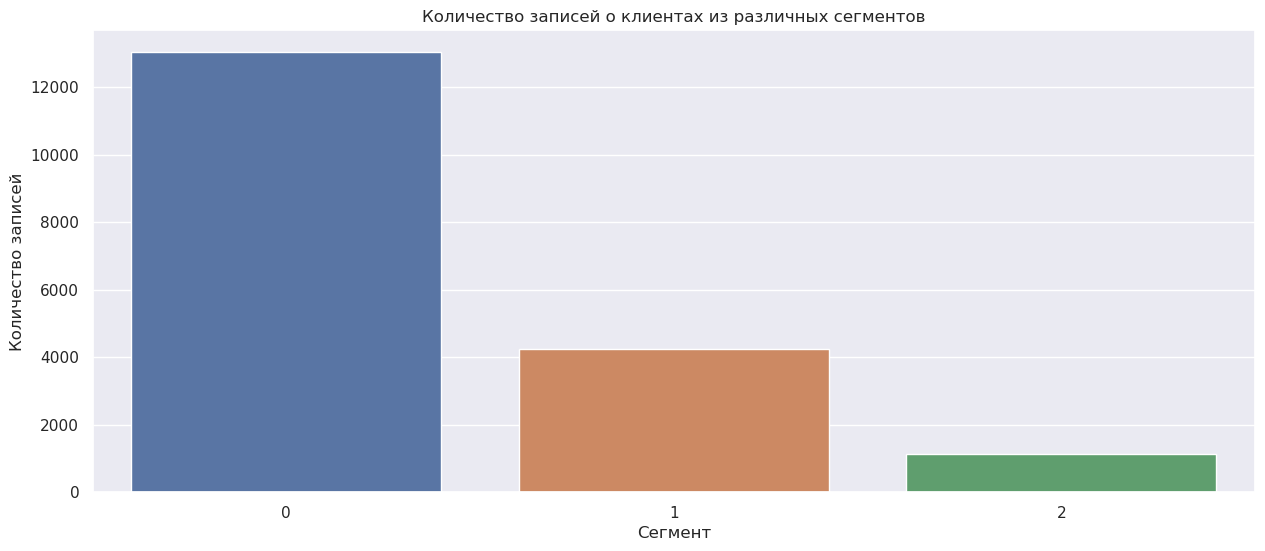

In [ ]:
sns.countplot(data=df, x='TARGET')\
.set(title='Количество записей о клиентах из различных сегментов',
    xlabel='Сегмент',
    ylabel='Количество записей');

Видно, что у нас наблюдается дисбаланс классов: примерно 70 процентов клиентов относятся к сегменту 0, а к сегменту 2 относятся всего 6 процентов клиентов. Это следует учитывать при обучении алгоритма.

### `FEATURE_...`

Посмотрим на колонки с наибольшим количеством пропусков. Возможно информация о распределении данных в этих колонках позволит нам сделать какие-то выводы.

In [ ]:
df.FEATURE_189.describe()

count     244.000000
mean      310.959016
std       272.957357
min         0.000000
25%       112.500000
50%       213.500000
75%       476.500000
max      1303.000000
Name: FEATURE_189, dtype: float64

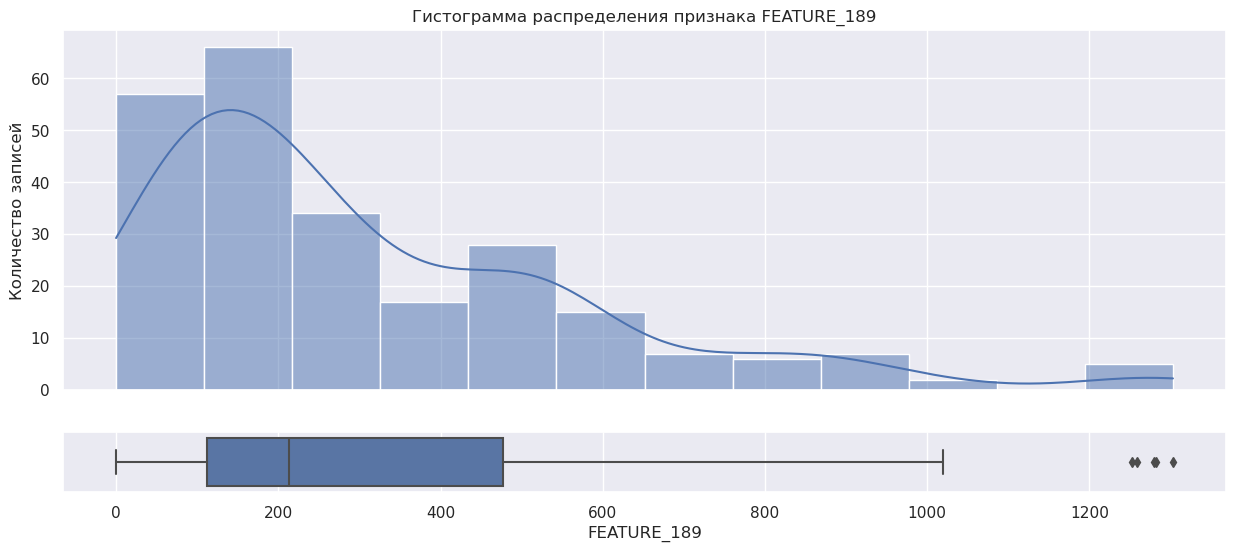

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 6), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[6,1]))
sns.histplot(data=df, x='FEATURE_189',
             kde=True, ax=axs_hist)\
.set(title='Гистограмма распределения признака FEATURE_189',
     ylabel='Количество записей')
sns.boxplot(data=df, x='FEATURE_189', ax=axs_box)\
.set(xlabel='FEATURE_189');

Каких-то закономерностей, которые позволили бы заполнять пропуски более осознанно, в данных мы не наблюдаем, посмотрим на какой-нибудь другой столбец с пропусками.

In [ ]:
df.FEATURE_193.describe()

count    9008.000000
mean      386.317853
std       391.549902
min      -219.011688
25%        92.409424
50%       205.964336
75%       575.073791
max      1535.146770
Name: FEATURE_193, dtype: float64

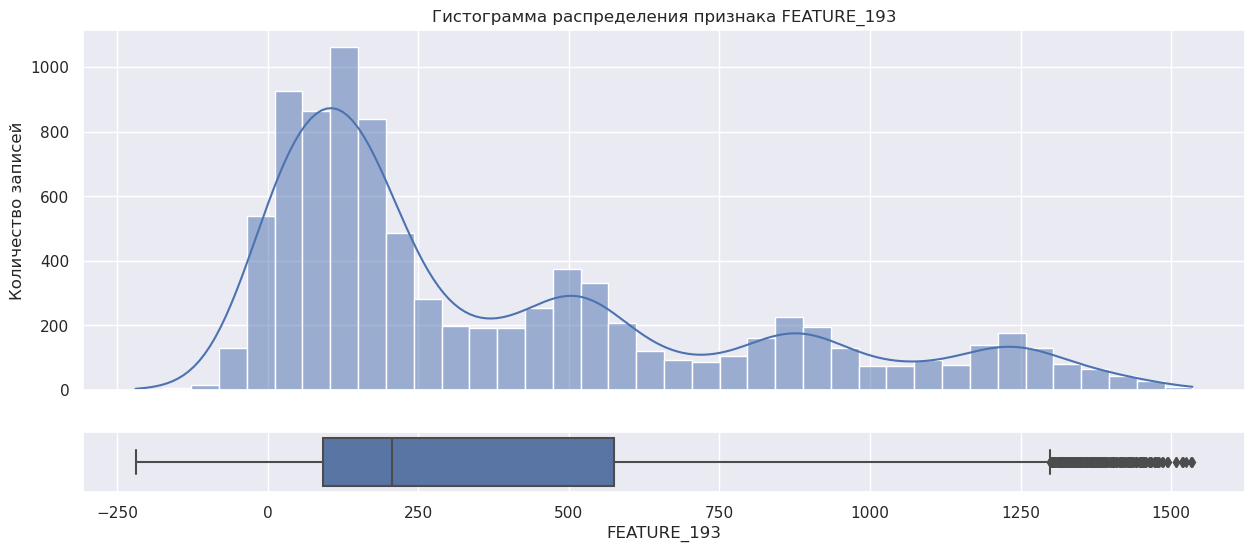

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 6), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[6,1]))
sns.histplot(data=df, x='FEATURE_193',
             kde=True, ax=axs_hist)\
.set(title='Гистограмма распределения признака FEATURE_193',
     ylabel='Количество записей')
sns.boxplot(data=df, x='FEATURE_193', ax=axs_box)\
.set(xlabel='FEATURE_193');

Данные выглядят подозрительно хорошо, похоже, что мы имеем дело со сгенированной выборкой. Однако в заполнении пропусков это нам не поможет.

### Визуальная оценка признаков

Посмотрим на попарные зависимости наших признаков. Их слишком много, чтобы мы могли оценить все соотношения, поэтому построим графики для первых и последних 10 признаков. Цветом будем выделять сегменты из целевого признака, вдруг удастся заметить какую-нибудь интересную закономерность.

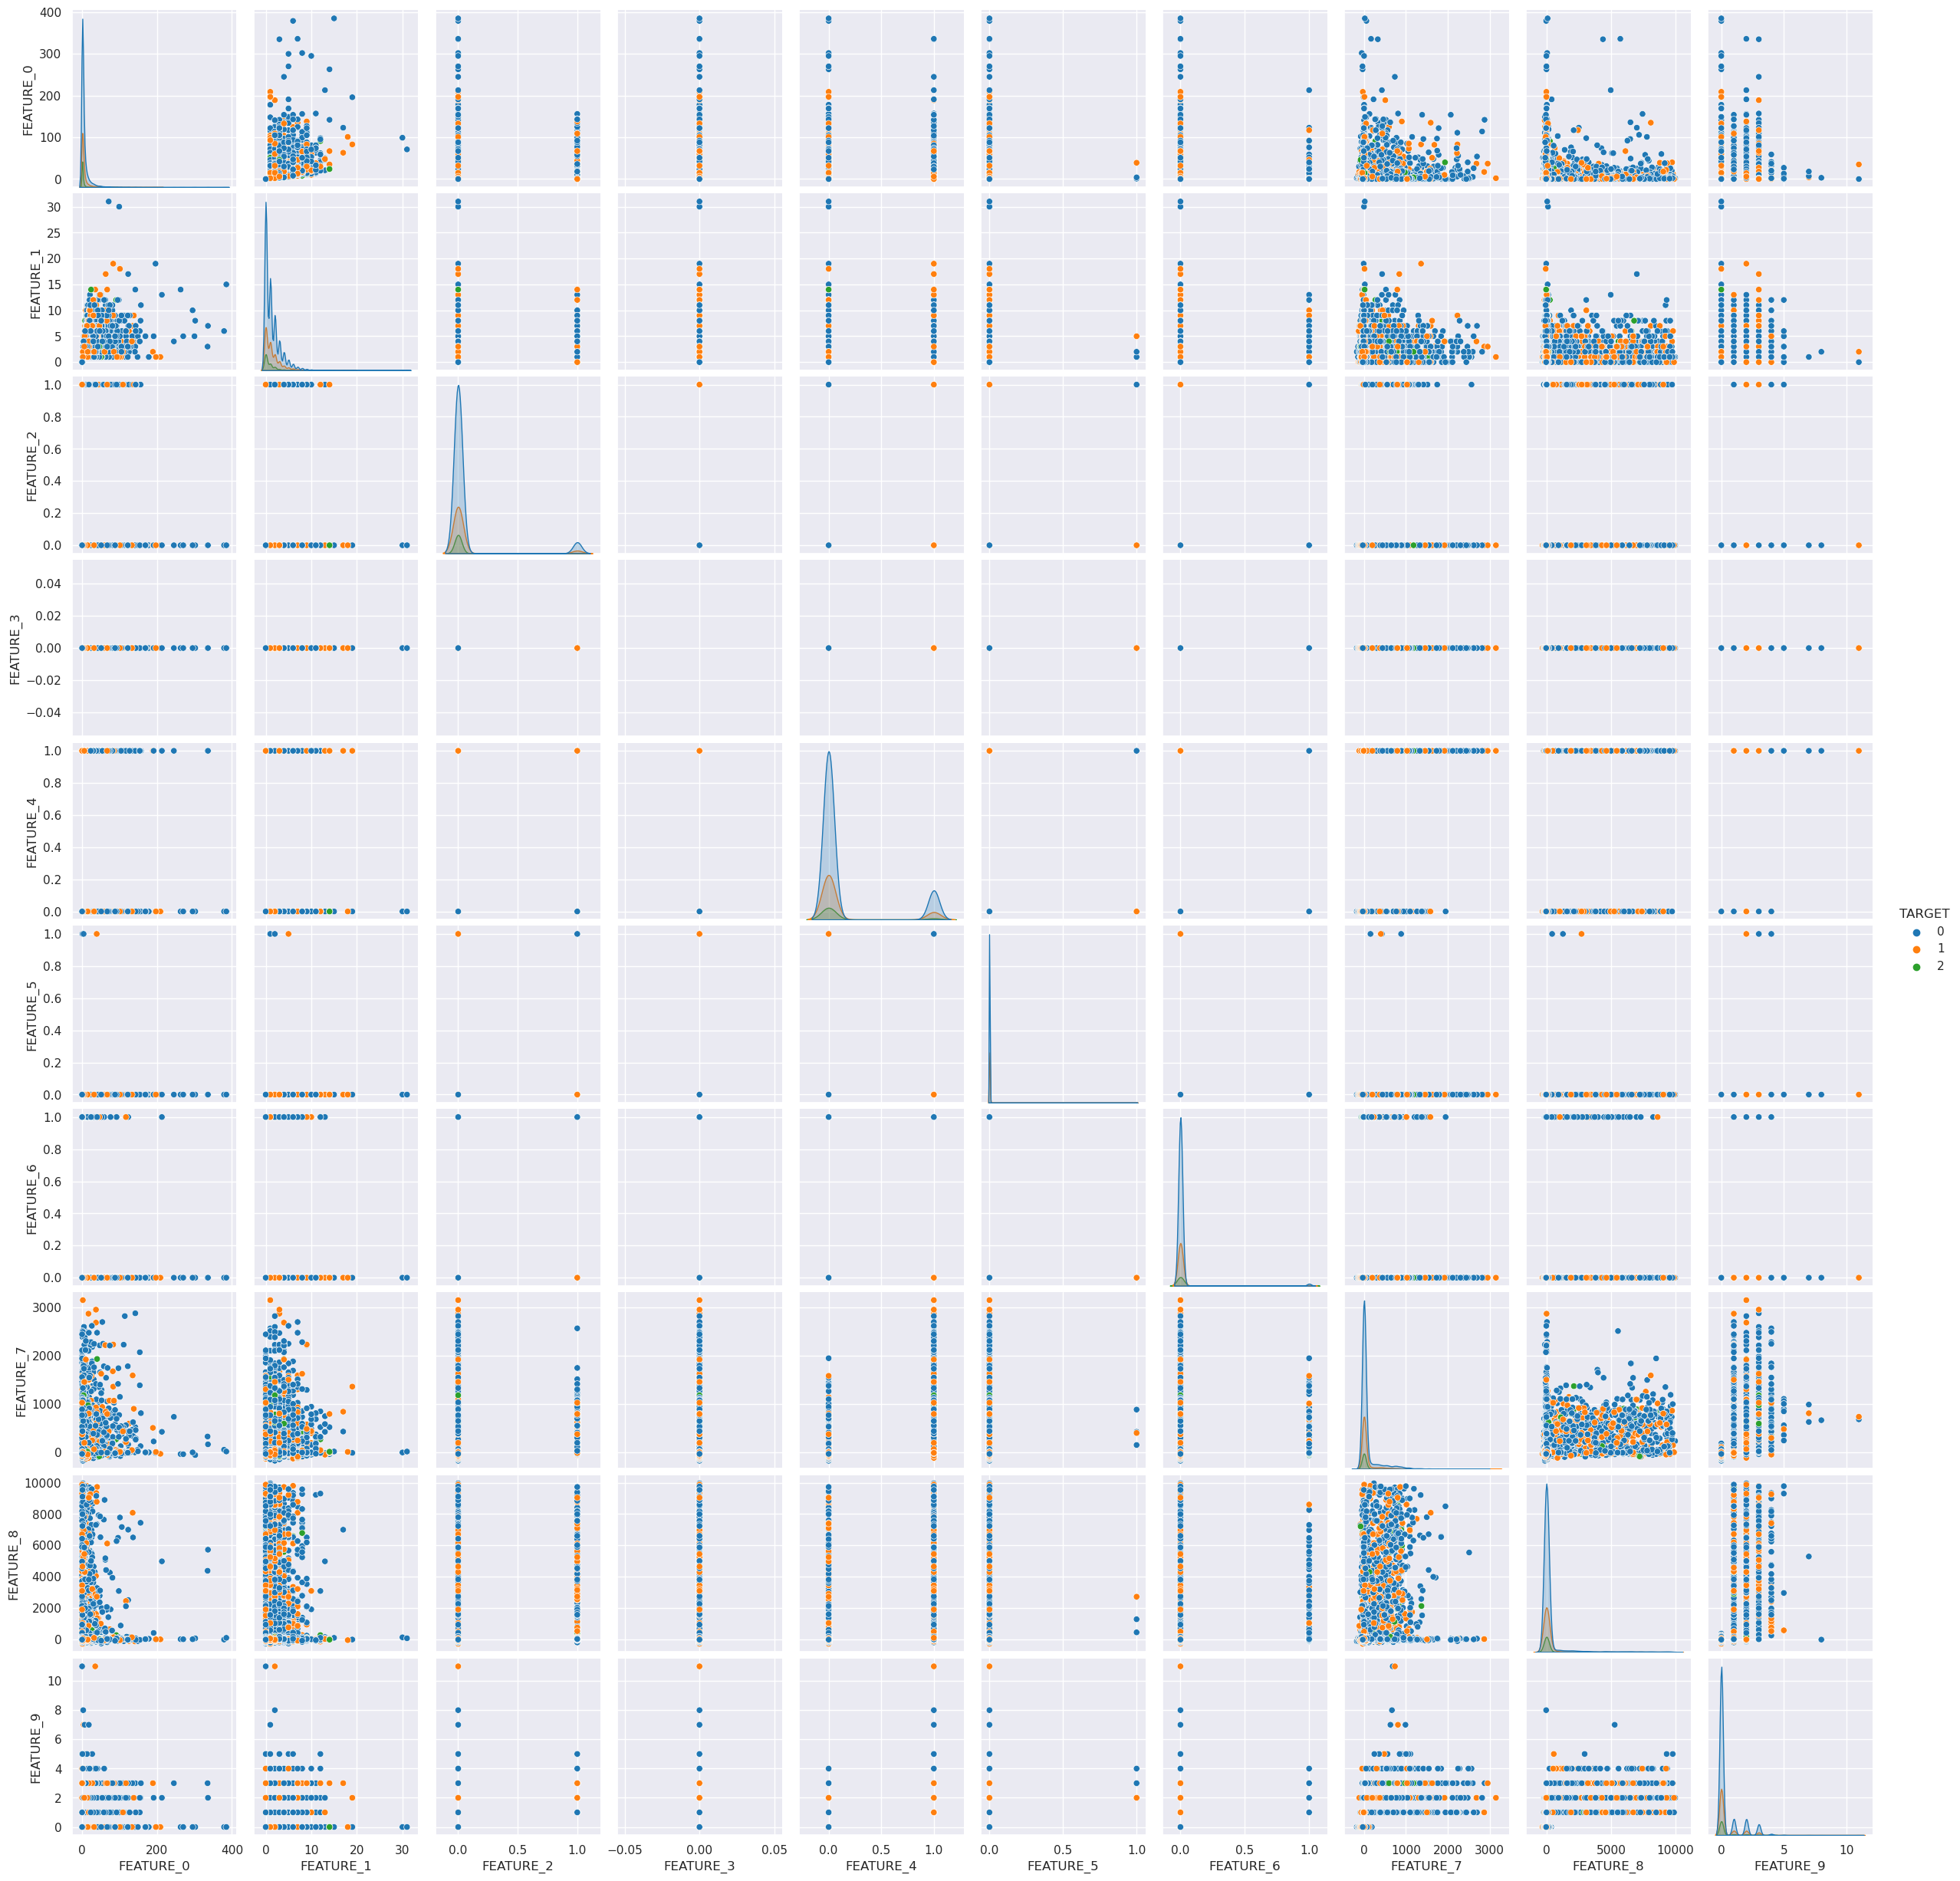

In [ ]:
g = sns.pairplot(data=df[['FEATURE_0', 'FEATURE_1', 'FEATURE_2',
                     'FEATURE_3', 'FEATURE_4', 'FEATURE_5',
                     'FEATURE_6', 'FEATURE_7', 'FEATURE_8',
                     'FEATURE_9', 'TARGET']], hue='TARGET', palette='tab10');

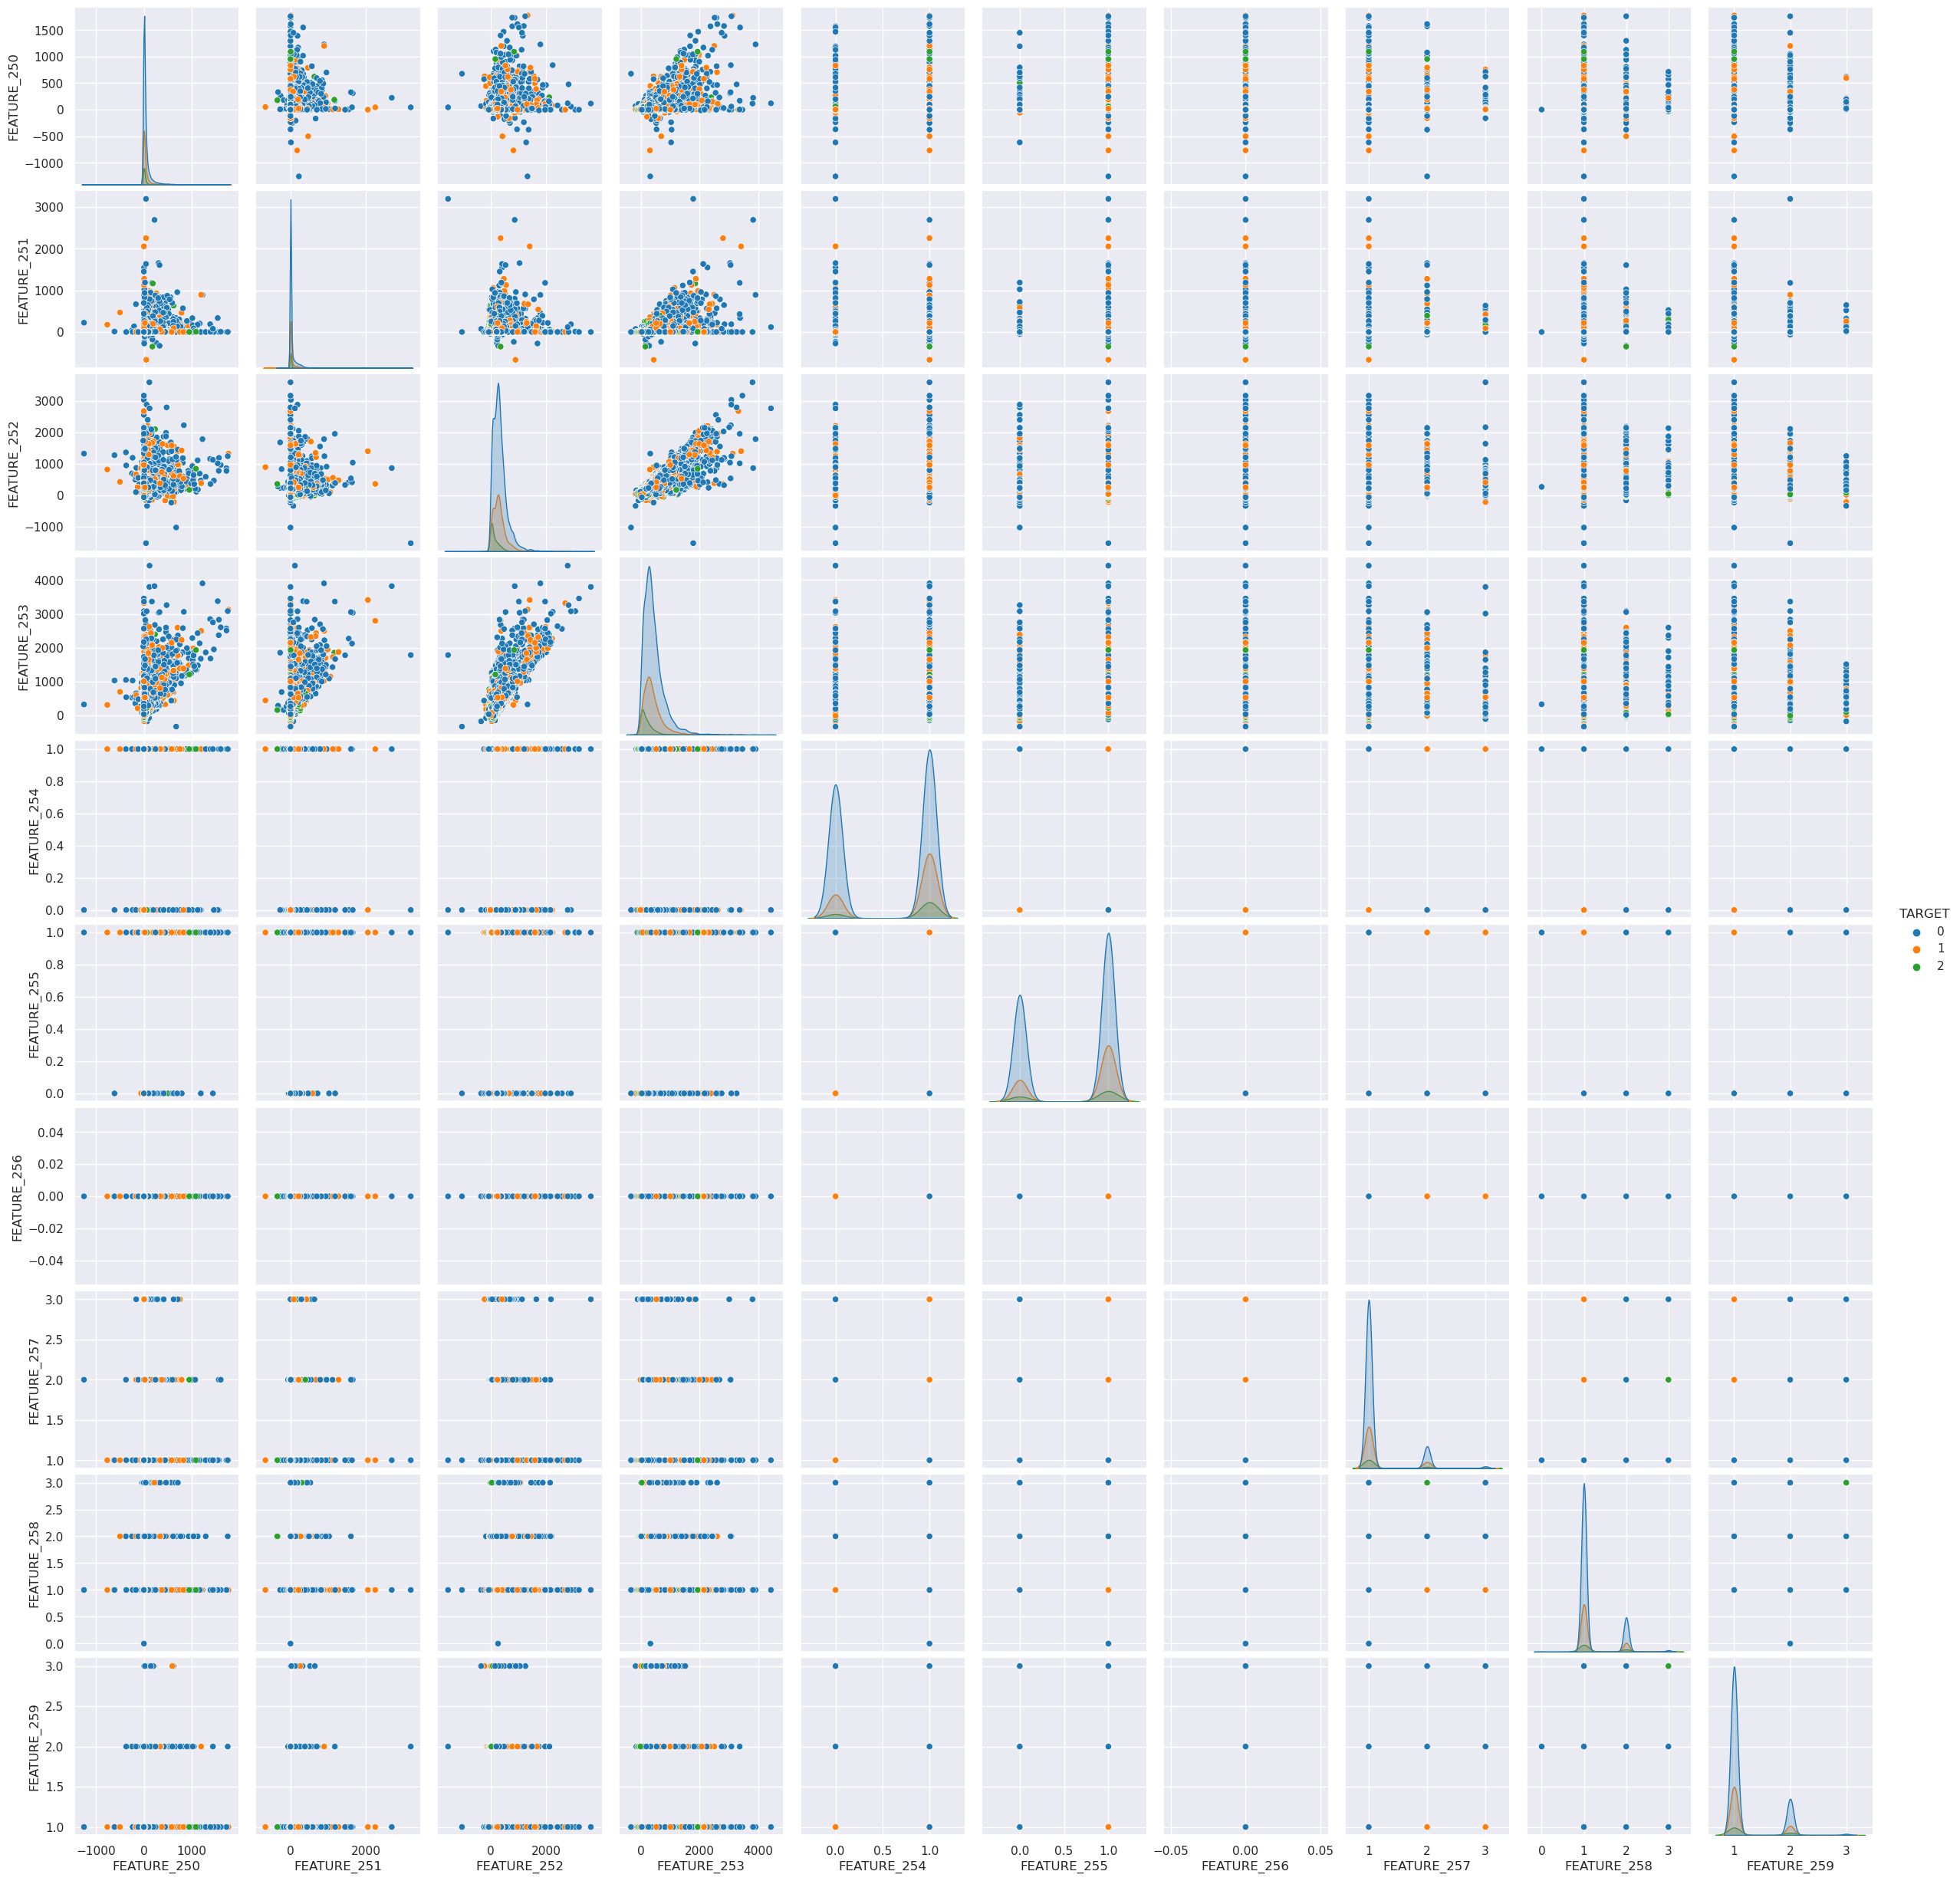

In [ ]:
g = sns.pairplot(data=df[['FEATURE_250', 'FEATURE_251', 'FEATURE_252',
                     'FEATURE_253', 'FEATURE_254', 'FEATURE_255',
                     'FEATURE_256', 'FEATURE_257', 'FEATURE_258',
                     'FEATURE_259', 'TARGET']], hue='TARGET', palette='tab10');

К сожалению, никаких ярко выраженных закономерностей, которые могли бы нам помочь, в глаза не бросается. Жаль.

### Промежуточный вывод

Мы провели небольшой исследовательский анализ данных, в ходе которого установили, что:
* все идентификаторы клиентов в поле `ID` уникальны и не содержат какой-либо дополнительной информации
* в поле `TARGET` наблюдается дисбаланс классов: примерно 70 процентов клиентов относятся к сегменту 0, а к сегменту 2 относятся всего 6 процентов клиентов

Мы также построили гистограммы для некоторых столбцов с большим количеством пропущенных данных, но не смогли обнаружить каких-либо закономерностей, которые позволили бы заполнять пропуски более информативно.

Построение графиков попарных зависимостей некоторых признаков с цветовым разделением данных, относящихся к разным сегментам, не позволило выявить никаких полезных закономерностей.

## Подготовка данных для обучения

Наша задача определения сегмента клиента по сути является задачей многоклассовой классификации. Мы опробуем различные алгоритмы и классификации и сравним их результаты. Однако различные алгоритмы требуют различной подготовки данных.

Например, для алгоритма `CatBoost`, реализованного компанией `Yandex` не требуется праварительного заполнения пропусков данных. Для этого алгоритма мы ограничимся формированием обучающей и валидационной выборки, которые будем хранить в классе `Pool`. 

Выделим в выборке обучающие и целевой признак.

In [ ]:
X = df.drop(['ID', 'TARGET'], axis=1)

In [ ]:
y = df['TARGET']

Разделим выборку на обучающую и валидационную часть. На валидацию оставим 20 процентов выборки. Так как наши классы не сбалансированы, убедимся, что в валидационной и обучающей части соотношение классов будет примерно одинаковым.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  stratify=y)

Соберём обучающие и валидационные выборки в `Pool`-ы. Это нужно для ускорения работы алгоритма `CatBoost`.

In [ ]:
train_pool = Pool(data=X_train, label=y_train)

In [ ]:
val_pool = Pool(data=X_val, label=y_val)

Для других алгоритмов, например, реализованных в библиотеке `sklearn` требуется заполнять пропущенные данные. У нас нет информации о том, какие данные хранятся в столбцах `FEATURE_...`, поэтому у нас остаётся два пути:
* заполнять пропуски средним значением для данной колонки
* заполнять пропуски значением из наиболее похожей строки (метод $k$-ближайших соседей).

Оба метода имеют свои достоинства и недостатки, поэтому поэкспериментируем с обоими. 

Заполнение пропущенных данных мы будем производить параллельно с обучением внутри `pipeline`-а, поэтому сейчас никакую обработку производить не будем.

## Обучение

Пришло время обучить модели. Нам необходимо выбрать модель, которая обеспечит максимальное значение метрики `F1 macro` на валидации. При этом нам надо учитывать, что наши классы не сбалансированы, а значит моделям будет сложно предсказывать метки редких классов.

Попробуем обучить и сравнить несколько моделей:
* `Ridge Classifier`
* `CatBoost`
* `LightGBM`

Для решения проблемы дисбаланса можно применять различные методы:
* использовать коррекцию весов классов, доступную в реализациях алгоримов (ключи `class_weight`, `auto_class_weights`)
* искусственно уменьшать размер выборки, чтобы выровнять баланс классов (т.н. `undersampling`)
* искусственно увеличивать размер выборки, чтобы выровнять баланс классов (т.н. `oversampling`).

Мы не можем заранее знать, какой метод окажется лучше для наших данных, поэтому попробуем все три метода.

Чтобы убедиться в адекватности предсказаний модели, обучим "глупый" классификатор, который будет предсказывать классы случайным образом, но с тем же дисбалансом, и сравним значения метрик.

### `Ridge Classifier`

Создадим `pipeline`-ы для всех проверяемых нами комбинаций.

In [ ]:
# базовый алгоритм, пропуски заполняем средним
ridge_pipe_simp = make_pipeline(SimpleImputer(), 
                                RidgeClassifierCV(cv=5))
# базовый алгоритм, пропуски заполняем через knn
ridge_pipe_knn = make_pipeline(KNNImputer(),
                               RidgeClassifierCV(cv=5))
# аналогично, но с автобалансировкой классов
ridge_pipe_simp_cw = make_pipeline(SimpleImputer(), 
                                RidgeClassifierCV(cv=5,
                                                 class_weight='balanced'))

ridge_pipe_knn_cw = make_pipeline(KNNImputer(),
                               RidgeClassifierCV(cv=5,
                                                class_weight='balanced'))
# undersampling
ridge_pipe_simp_us = make_pipeline(SimpleImputer(),
                                   NearMiss(),
                                RidgeClassifierCV(cv=5))

ridge_pipe_knn_us = make_pipeline(KNNImputer(),
                                  NearMiss(),
                               RidgeClassifierCV(cv=5))
# oversampling
ridge_pipe_simp_os = make_pipeline(SimpleImputer(),
                                   ADASYN(),
                                RidgeClassifierCV(cv=5))

ridge_pipe_knn_os = make_pipeline(KNNImputer(),
                                  ADASYN(),
                               RidgeClassifierCV(cv=5))

`Pipeline`-ы готовы, можно приступать к обучению.

In [ ]:
%%time
ridge_pipe_simp.fit(X_train, y_train)
ridge_pipe_knn.fit(X_train, y_train)

CPU times: user 3min 27s, sys: 6.6 s, total: 3min 33s
Wall time: 3min 24s


Pipeline(steps=[('knnimputer', KNNImputer()),
                ('ridgeclassifiercv',
                 RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), cv=5))])

In [ ]:
%%time
ridge_pipe_simp_cw.fit(X_train, y_train)
ridge_pipe_knn_cw.fit(X_train, y_train)

CPU times: user 3min 40s, sys: 10.3 s, total: 3min 50s
Wall time: 3min 33s


Pipeline(steps=[('knnimputer', KNNImputer()),
                ('ridgeclassifiercv',
                 RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]),
                                   class_weight='balanced', cv=5))])

In [ ]:
%%time
ridge_pipe_simp_us.fit(X_train, y_train)
ridge_pipe_knn_us.fit(X_train, y_train)

CPU times: user 3min 39s, sys: 4.3 s, total: 3min 43s
Wall time: 3min 29s


Pipeline(steps=[('knnimputer', KNNImputer()), ('nearmiss', NearMiss()),
                ('ridgeclassifiercv',
                 RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), cv=5))])

In [ ]:
%%time
ridge_pipe_simp_os.fit(X_train, y_train)
ridge_pipe_knn_os.fit(X_train, y_train)

CPU times: user 3min 54s, sys: 11.1 s, total: 4min 5s
Wall time: 3min 42s


Pipeline(steps=[('knnimputer', KNNImputer()), ('adasyn', ADASYN()),
                ('ridgeclassifiercv',
                 RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), cv=5))])

Получим предсказания и рассчитаем значения метрики.

In [ ]:
y_pred_simp = ridge_pipe_simp.predict(X_val)
y_pred_knn = ridge_pipe_knn.predict(X_val)

y_pred_simp_cw = ridge_pipe_simp_cw.predict(X_val)
y_pred_knn_cw = ridge_pipe_knn_cw.predict(X_val)

y_pred_simp_us = ridge_pipe_simp_us.predict(X_val)
y_pred_knn_us = ridge_pipe_knn_us.predict(X_val)

y_pred_simp_os = ridge_pipe_simp_os.predict(X_val)
y_pred_knn_os = ridge_pipe_knn_os.predict(X_val)

In [ ]:
f1_score(y_val, y_pred_simp, average='macro')

0.3894149703031407

In [ ]:
f1_score(y_val, y_pred_knn, average='macro')

0.38994939765848063

In [ ]:
f1_score(y_val, y_pred_simp_cw, average='macro')

0.462457987800358

In [ ]:
f1_score(y_val, y_pred_knn_cw, average='macro')

0.4590514857017254

In [ ]:
f1_score(y_val, y_pred_simp_us, average='macro')

0.23532248792168442

In [ ]:
f1_score(y_val, y_pred_knn_us, average='macro')

0.23192729190721748

In [ ]:
f1_score(y_val, y_pred_simp_os, average='macro')

0.4589040913669647

In [ ]:
f1_score(y_val, y_pred_knn_os, average='macro')

0.46745153518515875

Сведём полученные значения в таблицу.

| Модель | F1 (нач., mean) | F1 (нач., knn) | F1 (class_weights, mean) | F1 (class_weights, knn)| F1 (undersampling, mean) | F1 (undersampling, knn) | F1 (oversampling, mean) | F1 (oversampling, knn) |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | 
| Ridge | 0.389 | 0.390 | 0.462 | 0.459 | 0.235 | 0.232 | 0.459 | 0.467 |

Для модели с заполнением пропусков средним значением и балансировкой весов классов (она показала наилучшее значение метрики) построим матрицу ошибок.

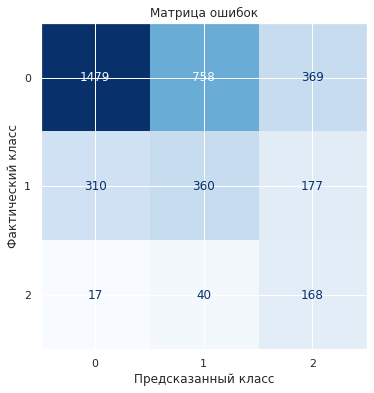

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
        ridge_pipe_simp_cw,
        X_val,
        y_val,
    colorbar=False,
    cmap=plt.cm.Blues
    )
disp.ax_.set_title('Матрица ошибок')
disp.ax_.set_xlabel('Предсказанный класс')
disp.ax_.set_ylabel('Фактический класс')
plt.show()

Видно, что модель относительно хорошо предсказывает клиентов из 0 сегмента, но плохо справляется с клиентами из 1 сегмента.

### LightGBM

Теперь попробуем аналогичным образом обучить модель `LightGBM` (градиентный бустинг на решающих деревьях).

In [ ]:
# базовый алгоритм, пропуски заполняем средним
lgbm_pipe_simp = make_pipeline(SimpleImputer(), 
                                LGBMClassifier(random_state=42))
# базовый алгоритм, пропуски заполняем через knn
lgbm_pipe_knn = make_pipeline(KNNImputer(),
                               LGBMClassifier(random_state=42))
# аналогично, но с автобалансировкой классов
lgbm_pipe_simp_cw = make_pipeline(SimpleImputer(), 
                                LGBMClassifier(random_state=42,
                                               class_weight='balanced'))

lgbm_pipe_knn_cw = make_pipeline(KNNImputer(),
                               LGBMClassifier(random_state=42,
                                              class_weight='balanced'))
# undersampling
lgbm_pipe_simp_us = make_pipeline(SimpleImputer(),
                                   NearMiss(),
                                LGBMClassifier(random_state=42))

lgbm_pipe_knn_us = make_pipeline(KNNImputer(),
                                  NearMiss(),
                               LGBMClassifier(random_state=42))
# oversampling
lgbm_pipe_simp_os = make_pipeline(SimpleImputer(),
                                   ADASYN(),
                                LGBMClassifier(random_state=42))

lgbm_pipe_knn_os = make_pipeline(KNNImputer(),
                                  ADASYN(),
                               LGBMClassifier(random_state=42))

`Pipeline`-ы готовы, можно приступать к обучению.

In [ ]:
%%time
lgbm_pipe_simp.fit(X_train, y_train)
lgbm_pipe_knn.fit(X_train, y_train)

CPU times: user 4min 21s, sys: 1.77 s, total: 4min 23s
Wall time: 3min 46s


Pipeline(steps=[('knnimputer', KNNImputer()),
                ('lgbmclassifier', LGBMClassifier(random_state=42))])

In [ ]:
%%time
lgbm_pipe_simp_cw.fit(X_train, y_train)
lgbm_pipe_knn_cw.fit(X_train, y_train)

CPU times: user 4min 24s, sys: 1.52 s, total: 4min 26s
Wall time: 3min 45s


Pipeline(steps=[('knnimputer', KNNImputer()),
                ('lgbmclassifier',
                 LGBMClassifier(class_weight='balanced', random_state=42))])

In [ ]:
%%time
lgbm_pipe_simp_us.fit(X_train, y_train)
lgbm_pipe_knn_us.fit(X_train, y_train)

CPU times: user 4min 14s, sys: 5.59 s, total: 4min 20s
Wall time: 3min 51s


Pipeline(steps=[('knnimputer', KNNImputer()), ('nearmiss', NearMiss()),
                ('lgbmclassifier', LGBMClassifier(random_state=42))])

In [ ]:
%%time
lgbm_pipe_simp_os.fit(X_train, y_train)
lgbm_pipe_knn_os.fit(X_train, y_train)

CPU times: user 5min 45s, sys: 3.12 s, total: 5min 48s
Wall time: 4min 35s


Pipeline(steps=[('knnimputer', KNNImputer()), ('adasyn', ADASYN()),
                ('lgbmclassifier', LGBMClassifier(random_state=42))])

Получим предсказания и рассчитаем значения метрики.

In [ ]:
y_pred_simp = lgbm_pipe_simp.predict(X_val)
y_pred_knn = lgbm_pipe_knn.predict(X_val)

y_pred_simp_cw = lgbm_pipe_simp_cw.predict(X_val)
y_pred_knn_cw = lgbm_pipe_knn_cw.predict(X_val)

y_pred_simp_us = lgbm_pipe_simp_us.predict(X_val)
y_pred_knn_us = lgbm_pipe_knn_us.predict(X_val)

y_pred_simp_os = lgbm_pipe_simp_os.predict(X_val)
y_pred_knn_os = lgbm_pipe_knn_os.predict(X_val)

In [ ]:
f1_score(y_val, y_pred_simp, average='macro')

0.49181453134977593

In [ ]:
f1_score(y_val, y_pred_knn, average='macro')

0.4970406307560357

In [ ]:
f1_score(y_val, y_pred_simp_cw, average='macro')

0.5422917895489008

In [ ]:
f1_score(y_val, y_pred_knn_cw, average='macro')

0.5421512279586667

In [ ]:
f1_score(y_val, y_pred_simp_us, average='macro')

0.1919834206527646

In [ ]:
f1_score(y_val, y_pred_knn_us, average='macro')

0.19130240759553022

In [ ]:
f1_score(y_val, y_pred_simp_os, average='macro')

0.49325022036723215

In [ ]:
f1_score(y_val, y_pred_knn_os, average='macro')

0.49082744825081964

Сведём полученные значения в таблицу.

| Модель | F1 (нач., mean) | F1 (нач., knn) | F1 (class_weights, mean) | F1 (class_weights, knn)| F1 (undersampling, mean) | F1 (undersampling, knn) | F1 (oversampling, mean) | F1 (oversampling, knn) |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | 
| Ridge | 0.389 | 0.390 | 0.462 | 0.459 | 0.235 | 0.232 | 0.459 | 0.467 |
| LGBM | 0.492 | 0.497 | 0.542 | 0.542 | 0.192 | 0.191 | 0.493 | 0.491 |

Для модели с заполнением пропусков средним значением и балансировкой весов классов (она показала наилучшее значение метрики) построим матрицу ошибок.

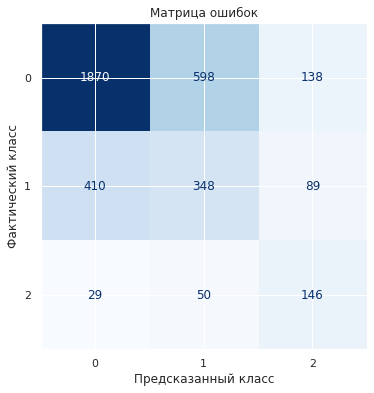

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
        lgbm_pipe_simp_cw,
        X_val,
        y_val,
    colorbar=False,
    cmap=plt.cm.Blues
    )
disp.ax_.set_title('Матрица ошибок')
disp.ax_.set_xlabel('Предсказанный класс')
disp.ax_.set_ylabel('Фактический класс')
plt.show()

Модель стала лучше находить клиентов из 0 сегмента, но первый сегмент всё ещё представляет проблему.

### `CatBoost`

Теперь обучим модель `CatBoost`. В данной модели реализован собственный механизм заполнения пропусков, более того, её разработчики не рекомендуют заполнять пропуски сторонними средствами. Поэтому в случае `CatBoost` мы проверим всего два подхода: без балансировки весов и с автоматической балансировкой.

Обучим классификатор без учёта дисбаланса классов.

In [ ]:
cb_cls = CatBoostClassifier(iterations=2000, 
                            random_seed=42,
                            verbose=0,
                            eval_metric='TotalF1:average=Macro')

In [ ]:
cb_cls.fit(train_pool, use_best_model=True, eval_set=val_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
y_pred = cb_cls.predict(val_pool)

In [ ]:
f1_score(y_val, y_pred, average='macro')

0.5098197327815519

Теперь применим автоматическую балансировку классов.

In [ ]:
cb_cls_acw = CatBoostClassifier(iterations=2000,
                            random_seed=42,
                            verbose=0,
                            auto_class_weights='SqrtBalanced',
                            eval_metric='TotalF1:average=Macro')

In [ ]:
cb_cls_acw.fit(train_pool, use_best_model=True, eval_set=val_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
y_pred = cb_cls_acw.predict(val_pool)

In [ ]:
f1_score(y_val, y_pred, average='macro')

0.5504921987650345

Создадим для результатов `CatBoost` отдельную таблицу и расположим её рядом с первой.

| Модель | F1 (нач.) | F1 (баланс.) |
| -- | -- | -- |
| CatBoost | 0.510 | 0.550 |

| Модель | F1 (нач., mean) | F1 (нач., knn) | F1 (class_weights, mean) | F1 (class_weights, knn)| F1 (undersampling, mean) | F1 (undersampling, knn) | F1 (oversampling, mean) | F1 (oversampling, knn) |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | 
| Ridge | 0.389 | 0.390 | 0.462 | 0.459 | 0.235 | 0.232 | 0.459 | 0.467 |
| LGBM | 0.492 | 0.497 | 0.542 | 0.542 | 0.192 | 0.191 | 0.493 | 0.491 |

Построим матрицу ошибок для `CatBoost` с балансом весов классов.

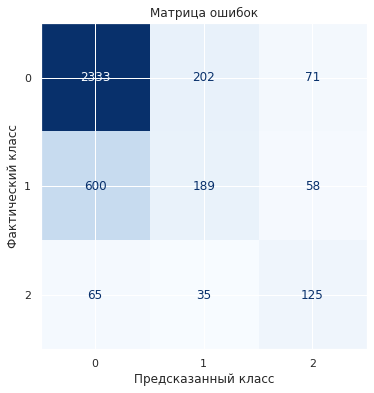

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
        cb_cls_acw,
        X_val,
        y_val,
    colorbar=False,
    cmap=plt.cm.Blues
    )
disp.ax_.set_title('Матрица ошибок')
disp.ax_.set_xlabel('Предсказанный класс')
disp.ax_.set_ylabel('Фактический класс')
plt.show()

Видно, что модель `CatBoost` довольно сильно ошибается в предсказании первого сегмента, но зато научилась довольно хорошо предсказывать 0 и 2 сегменты.

### Глупый классификатор

Чтобы убедиться в адекватности наших моделей обучим и "глупый" классификатор, который будет предсказывать классы случайным образом, но с сохранением начального баланса классов.

In [ ]:
dm_pipe_simp = make_pipeline(SimpleImputer(), 
                         DummyClassifier(random_state=42,
                                         strategy='stratified'))

In [ ]:
dm_pipe_simp.fit(X_train, y_train)

Pipeline(steps=[('knnimputer', KNNImputer()),
                ('dummyclassifier',
                 DummyClassifier(random_state=42, strategy='stratified'))])

In [ ]:
y_pred = dm_pipe_simp.predict(X_val)

In [ ]:
f1_score(y_val, y_pred, average='macro')

0.3270773121913672

Дополним наши таблицы:

| Модель | F1 (нач.) | F1 (баланс.) |
| -- | -- | -- |
| CatBoost | 0.510 | 0.550 |

| Модель | F1 (нач., mean) | F1 (нач., knn) | F1 (class_weights, mean) | F1 (class_weights, knn)| F1 (undersampling, mean) | F1 (undersampling, knn) | F1 (oversampling, mean) | F1 (oversampling, knn) |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | 
| Ridge | 0.389 | 0.390 | 0.462 | 0.459 | 0.235 | 0.232 | 0.459 | 0.467 |
| LGBM | 0.492 | 0.497 | 0.542 | 0.542 | 0.192 | 0.191 | 0.493 | 0.491 |
| Dummy | 0.327 | --- | --- | --- | --- | --- | --- | --- |

Видно, что за исключением применения `undersampling`-а все модели прошли проверку на адекватность и показали результат лучше, чем у глупого классификатора.

### Промежуточный вывод

Мы обучили и сравнили несколько моделей:
* `Ridge Classifier`
* `CatBoost`
* `LightGBM`

Для решения проблемы дисбаланса мы применили три различных метода:
* использовали коррекцию весов классов
* искусственно уменьшали размер выборки
* искусственно увеличивали размер выборки

Для различных комбинаций моделей и методов борьбы с дисбалансом мы рассчитали значения метрики `F1 macro`.

Чтобы убедиться в адекватности предсказаний модели, мы обучили "глупый" классификатор, который будет предсказывать классы случайным образом, но с сохранением дисбаланса.

Результирующие значения метрики `F1 macro` на валидационной выборке представлены в таблицах ниже.

| Модель | F1 (нач.) | F1 (баланс.) |
| -- | -- | -- |
| CatBoost | 0.510 | 0.550 |

| Модель | F1 (нач., mean) | F1 (нач., knn) | F1 (class_weights, mean) | F1 (class_weights, knn)| F1 (undersampling, mean) | F1 (undersampling, knn) | F1 (oversampling, mean) | F1 (oversampling, knn) |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | 
| Ridge | 0.389 | 0.390 | 0.462 | 0.459 | 0.235 | 0.232 | 0.459 | 0.467 |
| LGBM | 0.492 | 0.497 | 0.542 | 0.542 | 0.192 | 0.191 | 0.493 | 0.491 |
| Dummy | 0.327 | --- | --- | --- | --- | --- | --- | --- |

Из данных таблиц видно, что наилучшее значение метрики удалось достичь для модели `CatBoost` с автоматической балансировкой классов.

## Предсказания для тестовой выборки

Для получения предсказаний на тестовой выборке мы будем использовать `CatBoost`. Попробуем ещё немного улучшить значения метрики `F1` за счёт подбора гипер-параметров.

Так как мы будем использовать кросс-валидацию, нам больше не нужна валидационная выборка.

In [ ]:
full_pool = Pool(data=X, label=y)

In [ ]:
cb_cls = CatBoostClassifier(random_seed=42,
                            auto_class_weights='SqrtBalanced',
                            verbose=0,
                            eval_metric='TotalF1:average=Macro')

In [ ]:
grid = {'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

In [ ]:
grid_search_result = cb_cls.grid_search(grid, 
                                       full_pool,
                                       verbose=0,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.5467998468
bestIteration = 991


bestTest = 0.5467845412
bestIteration = 925


bestTest = 0.5470113661
bestIteration = 995


bestTest = 0.5467717774
bestIteration = 921


bestTest = 0.5462964834
bestIteration = 794


bestTest = 0.5495089215
bestIteration = 784


bestTest = 0.5412430725
bestIteration = 717


bestTest = 0.5490046046
bestIteration = 855


bestTest = 0.5481697443
bestIteration = 773


bestTest = 0.5453012604
bestIteration = 993


bestTest = 0.5363604822
bestIteration = 503


bestTest = 0.5406289223
bestIteration = 988


bestTest = 0.5472471566
bestIteration = 860


bestTest = 0.5453595856
bestIteration = 946


bestTest = 0.5485421084
bestIteration = 829

Training on fold [0/3]

bestTest = 0.5474686766
bestIteration = 906

Training on fold [1/3]

bestTest = 0.5252254266
bestIteration = 726

Training on fold [2/3]

bestTest = 0.5479538849
bestIteration = 871



Улучшить значение метрики нам не удалось, а жаль. Подготовим предсказания для тестовой выборки.

In [ ]:
test = pd.read_csv('contest_test.csv')

In [ ]:
test.head()

ID  FEATURE_0  FEATURE_1  FEATURE_2  FEATURE_3  FEATURE_4  \
0    84728433        0.0        0.0        0.0        0.0        0.0   
1   335016156        0.0        0.0        0.0        0.0        0.0   
2  1163752045       16.0        4.0        0.0        0.0        0.0   
3    84929758        2.0        1.0        0.0        0.0        0.0   
4   143090121        2.0        1.0        0.0        0.0        1.0   

   FEATURE_5  FEATURE_6   FEATURE_7    FEATURE_8  ...  FEATURE_250  \
0        0.0        0.0   35.265322   110.813724  ...          0.0   
1        0.0        0.0   51.316538    14.427879  ...          0.0   
2        0.0        1.0  457.087009  1172.556882  ...        131.0   
3        0.0        0.0   29.672314    58.511494  ...          0.0   
4        0.0        0.0  522.148408  2724.481080  ...         50.0   

   FEATURE_251  FEATURE_252  FEATURE_253  FEATURE_254  FEATURE_255  \
0          0.0   436.883761   427.497873          0.0          1.0   
1          0.0    53.400612    58.863404          1.0          1.0   
2        151.0   217.419547   490.478263          0.0          1.0   
3          0.0   657.453708   692.191717          1.0          1.0   
4        188.0  1253.064074  1670.514312          0.0          1.0   

   FEATURE_256  FEATURE_257  FEATURE_258  FEATURE_259  
0          0.0          1.0          1.0          1.0  
1          0.0          1.0          1.0          1.0  
2          0.0          1.0          1.0          1.0  
3          0.0          2.0          1.0          1.0  
4          0.0          1.0          1.0          2.0  

[5 rows x 261 columns]

In [ ]:
X_test = test.drop('ID', axis=1)

In [ ]:
y_pred = cb_cls.predict(X_test)

In [ ]:
ans = pd.DataFrame(test['ID'].copy())

In [ ]:
ans['TARGET'] = y_pred

Ответы подготовлены, осталось только сохранить.

In [ ]:
ans.to_csv('contest_answer.csv', sep=',', index=False, header=True)

## Вывод

В данном проекте перед нами стояла задача сегментировать клиентов по трем категориям (0, 1, 2). Необходимо было разработать модель, предсказывающую к какому из трех сегментов относится каждый клиент.

Точность предсказания оценивалась метрикой [`macro f1 score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html). 

Мы загрузили файл обучающей выборки, содержащий более чем 18 тысяч записей. Все обучающие признаки обезличены (названия колонок не позволяют судить о содержащихся в них данных). В некоторых колонках содержались пропуски данных. 

Мы провели небольшой исследовательский анализ данных, в ходе которого установили, что:
* все идентификаторы клиентов в поле `ID` уникальны и не содержат какой-либо дополнительной информации
* в поле `TARGET` наблюдается дисбаланс классов: примерно 70 процентов клиентов относятся к сегменту 0, а к сегменту 2 относятся всего 6 процентов клиентов

Мы построили гистограммы для некоторых столбцов с большим количеством пропущенных данных, но не смогли обнаружить каких-либо закономерностей, которые позволили бы заполнять пропуски более информативно.

Мы построили графики попарных зависимостей первых и последних десяти признаков, при этом разделили точки, относящиеся к различным сегментам, цветами. Визуальный анализ полученных графиков не позволил нам выявить каких-либо полезных закономерностей.

Для получения предсказаний мы обучили и сравнили несколько моделей:
* `Ridge Classifier`
* `CatBoost`
* `LightGBM`

Проблема дисбаланса решалась тремя методами:
* мы использовали коррекцию весов классов
* искусственно уменьшали размер выборки
* искусственно увеличивали размер выборки

Для различных комбинаций моделей и методов борьбы с дисбалансом мы рассчитали значения метрики `F1 macro`.

Чтобы убедиться в адекватности предсказаний модели, мы обучили "глупый" классификатор, который предсказывал классы случайным образом, но с сохранением дисбаланса.

Результирующие значения метрики `F1 macro` на валидационной выборке представлены в таблицах ниже.

| Модель | F1 (нач.) | F1 (баланс.) |
| -- | -- | -- |
| CatBoost | 0.510 | 0.550 |

| Модель | F1 (нач., mean) | F1 (нач., knn) | F1 (class_weights, mean) | F1 (class_weights, knn)| F1 (undersampling, mean) | F1 (undersampling, knn) | F1 (oversampling, mean) | F1 (oversampling, knn) |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | 
| Ridge | 0.389 | 0.390 | 0.462 | 0.459 | 0.235 | 0.232 | 0.459 | 0.467 |
| LGBM | 0.492 | 0.497 | 0.542 | 0.542 | 0.192 | 0.191 | 0.493 | 0.491 |
| Dummy | 0.327 | --- | --- | --- | --- | --- | --- | --- |

Из данных таблиц видно, что наилучшее значение метрики удалось достичь для модели `CatBoost` с автоматической балансировкой классов.

Так как модель `CatBoost` показала наилучшие значения метрики, мы попытались дополнительно улучшить предсказания за счёт подбора гипер-параметров на кросс-валидации. С ожалению, нам не удалось добиться сколько-нибудь серьёзного улучшения результата.

Наконец, мы загрузили файл с тестовыми данными и подготовили по нему предсказания. Результаты работы мы сохранили в файле `contest_answer.csv`.